In [1]:
'''Example of VAE and AE on MNIST dataset using a CNN.
There are three models the encoder, decoder and autoencoder.
The encoder generates the latent variables and the 
decoder can be used to generate MNIST digits by sampling. The VAE
restricts the latent vector/variable to be from a Gaussian distribution 
with mean = 0 and std = 1. This example was adapted fro
# Reference
[1] Kingma, Diederik P., and Max Welling.
"Auto-Encoding Variational Bayes."
https://arxiv.org/abs/1312.6114
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Load the module we need
# Note that we are import the Keras backend, which is assumed to be Tensorflow
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, MaxPooling2D
from tensorflow.keras.layers import UpSampling2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras import backend as K

from tensorflow.keras.datasets import mnist
import numpy as np

import matplotlib.pyplot as plt



from tensorflow.keras.layers import Lambda
from tensorflow.keras.losses import mean_squared_error, binary_crossentropy, mse, KLDivergence
from tensorflow.keras.utils import plot_model

import tensorflow as tf
import os

In [2]:
# This function samples random points from a distribution
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent subspace
    if (model_name == 'vae_mlp'):
        z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    else:
        z_mean = encoder.predict(x_test,batch_size=batch_size)
    
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(np.amin(z_mean[:,0]), np.amax(z_mean[:,0]), n)
    grid_y = np.linspace(np.amin(z_mean[:,1]), np.amax(z_mean[:,1]), n)[::-1]

    z_sample = np.zeros((1,5))
    z_sample[0,2] = np.mean(z_mean[:,2])
    z_sample[0,3] = np.mean(z_mean[:,3])
    z_sample[0,4] = np.mean(z_mean[:,4])    
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample[0,0] = xi
            z_sample[0,1] = yi
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

In [3]:
# Load MNIST datasets (training and test)
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) 
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)) 

11490434/11490434 [==============================] - 15s 1us/step


In [4]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [14]:
# Define the Encoder, inputs are the MNIST 28x28 greyscale images 
input_img = Input(shape=(28, 28, 1))  

x = Conv2D(32, (3, 3), activation='relu',padding='same')(input_img)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu')(x)
x = Reshape((128,))(x)
z = Dense(5,activation='linear')(x)    

encoded = Model(input_img,z,name='encoded')
encoded.summary()
plot_model(encoded, to_file='AE_encoded.png', show_shapes=True)            

# Latent space is a 5 dimensional vector space

# This is the decoder, it take the 5 dim latent vector and generates a 28x28 image
lats = Input(shape=(5,),name='latent')
x = Dense(128,activation='relu')(lats)
x = Reshape((4,4,8))(x)
x = Conv2DTranspose(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(32, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
rec = Conv2DTranspose(1, (3, 3), activation='relu',padding="same")(x)

decoded = Model(lats,rec,name='decoded')
decoded.summary()
plot_model(decoded, to_file='AE_decoded.png', show_shapes=True)     

# The autoencoder takes the image as input encodes it, then decodes it
rec = decoded(encoded(input_img))
autoencoder = Model(input_img,rec)

reconstruction_loss = tf.reduce_mean(1000.0*tf.square(input_img-rec),axis=(1,2))
autoencoder.add_loss(reconstruction_loss)
autoencoder.compile(optimizer='adadelta')
autoencoder.summary()

Model: "encoded"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 12, 12, 16)        4624      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 6, 6, 16)          0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 8)           1160

In [6]:
# Train the model, this can take some time
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))
autoencoder.save_weights('ae_mlp_mnist.h5')

Epoch 1/100
469/469 [==============================] - 14s 27ms/step - loss: 109.0672 - val_loss: 106.6793
Epoch 2/100
469/469 [==============================] - 17s 37ms/step - loss: 78.5676 - val_loss: 65.1713
Epoch 3/100
469/469 [==============================] - 16s 35ms/step - loss: 64.0214 - val_loss: 62.7135
Epoch 4/100
469/469 [==============================] - 17s 36ms/step - loss: 62.0314 - val_loss: 60.7732
Epoch 5/100
469/469 [==============================] - 16s 35ms/step - loss: 60.3103 - val_loss: 59.5992
Epoch 6/100
469/469 [==============================] - 17s 35ms/step - loss: 59.3490 - val_loss: 58.9648
Epoch 7/100
469/469 [==============================] - 17s 36ms/step - loss: 58.8306 - val_loss: 58.5323
Epoch 8/100
469/469 [==============================] - 18s 37ms/step - loss: 58.4568 - val_loss: 58.1870
Epoch 9/100
469/469 [==============================] - 17s 36ms/step - loss: 58.1476 - val_loss: 57.8872
Epoch 10/100
469/469 [==============================]

469/469 [==============================] - 16s 34ms/step - loss: 49.4723 - val_loss: 49.1931
Epoch 79/100
469/469 [==============================] - 16s 34ms/step - loss: 49.3949 - val_loss: 49.1146
Epoch 80/100
469/469 [==============================] - 18s 39ms/step - loss: 49.3175 - val_loss: 49.0377
Epoch 81/100
469/469 [==============================] - 15s 31ms/step - loss: 49.2416 - val_loss: 48.9588
Epoch 82/100
469/469 [==============================] - 14s 31ms/step - loss: 49.1658 - val_loss: 48.8814
Epoch 83/100
469/469 [==============================] - 14s 30ms/step - loss: 49.0908 - val_loss: 48.8052
Epoch 84/100
469/469 [==============================] - 14s 30ms/step - loss: 49.0161 - val_loss: 48.7293
Epoch 85/100
469/469 [==============================] - 14s 30ms/step - loss: 48.9417 - val_loss: 48.6552
Epoch 86/100
469/469 [==============================] - 14s 30ms/step - loss: 48.8677 - val_loss: 48.5796
Epoch 87/100
469/469 [==============================] - 14s

313/313 [==============================] - 2s 4ms/step


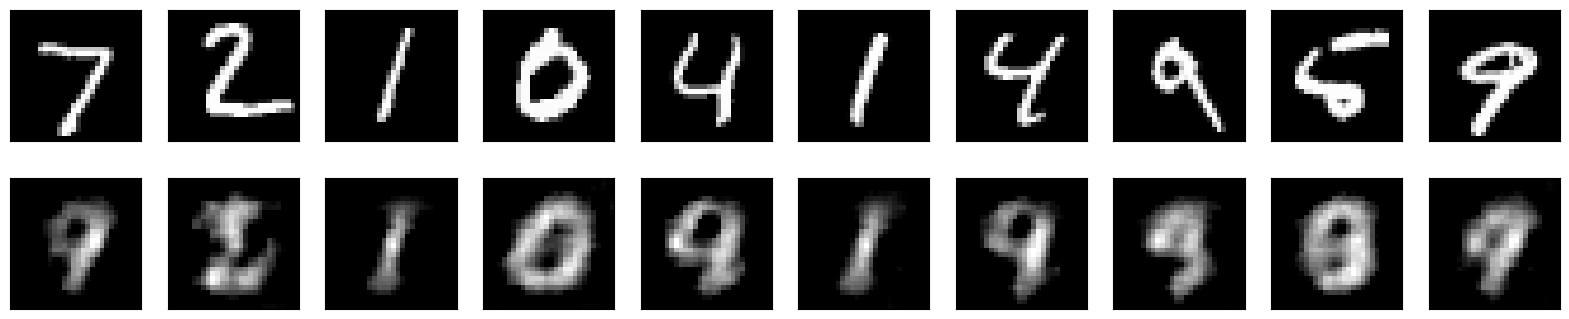

In [7]:
# Show a sample of test images that have been through the autoencoder
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

79/79 [==============================] - 0s 3ms/step


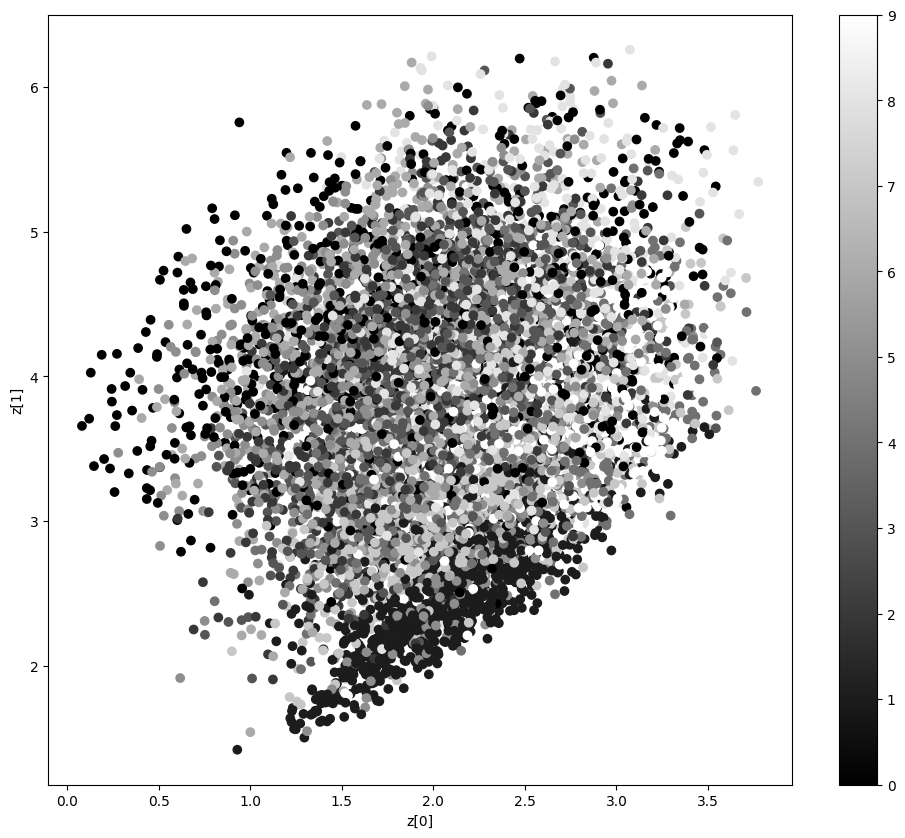

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 13ms/step


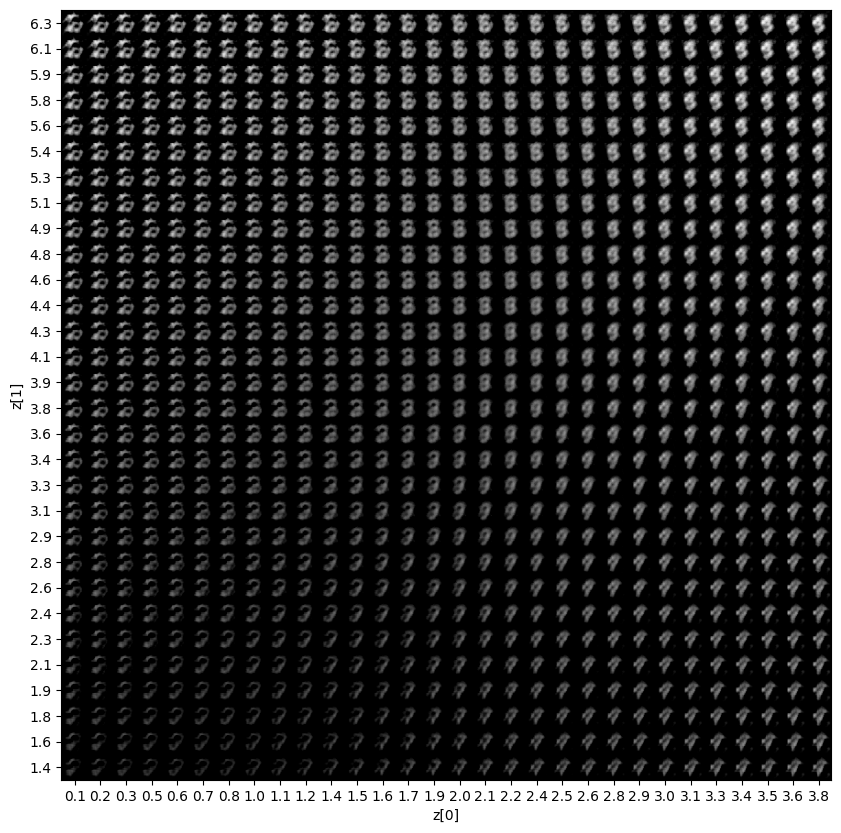

In [8]:
# Use the plot_results function to show a latent subspace 
# Use a grid of latent variables to generate MNIST images
batch_size=128
plot_results((encoded,decoded),
            (x_test,y_test),
                 batch_size=batch_size,
                 model_name="AE")

In [9]:
input_shape = (28,28,1)
batch_size = 128
latent_dim = 5
epochs = 20


# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Conv2D(32, (3, 3), activation='relu',padding='same')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu')(x)
x = Reshape((128,))(x)
z_mean = Dense(latent_dim,activation='linear',name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var',activation='linear')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)



# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(128,activation='relu')(latent_inputs)
x = Reshape((4,4,8))(x)
x = Conv2DTranspose(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(32, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
outputs = Conv2DTranspose(1, (3, 3), activation='relu',padding='same')(x)


# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')
vae.summary()
plot_model(vae,to_file='vae_mlp.png',show_shapes=True)


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 28, 28, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)           0         ['conv2d_3[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_4 (Conv2D)           (None, 12, 12, 16)           4624      ['max_pooling2d_2[0][0]'

In [10]:
# Generate the new loss function with the reconstruction error and the Kulback-Leibler
# divergence

reconstruction_loss = tf.reduce_mean(1000.0*tf.square(inputs-outputs),axis=(1,2))
z = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = tf.reduce_sum(-0.5*z, axis=-1)
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.add_metric(tf.reduce_sum(1000.0*tf.square(inputs-outputs),axis=(1,2)),name='rec_loss',aggregation='mean')
vae.add_metric(tf.reduce_sum(-0.5*z, axis=-1),name='kl_loss',aggregation='mean')
vae.compile(optimizer='adam')

# Train the model
vae.fit(x_train,epochs=epochs,batch_size=128)
vae.save_weights('vae_mlp_mnist.h5')



Epoch 1/20
469/469 [==============================] - 16s 32ms/step - loss: 57.0238 - rec_loss: 40595.9297 - kl_loss: 5.2481
Epoch 2/20
469/469 [==============================] - 16s 33ms/step - loss: 45.5820 - rec_loss: 29944.4727 - kl_loss: 7.3882
Epoch 3/20
469/469 [==============================] - 16s 33ms/step - loss: 43.6583 - rec_loss: 28187.5879 - kl_loss: 7.7046
Epoch 4/20
469/469 [==============================] - 16s 33ms/step - loss: 42.6896 - rec_loss: 27272.7500 - kl_loss: 7.9035
Epoch 5/20
469/469 [==============================] - 16s 33ms/step - loss: 42.1399 - rec_loss: 26741.4316 - kl_loss: 8.0321
Epoch 6/20
469/469 [==============================] - 16s 33ms/step - loss: 41.7481 - rec_loss: 26375.9004 - kl_loss: 8.1053
Epoch 7/20
469/469 [==============================] - 15s 33ms/step - loss: 41.4376 - rec_loss: 26063.3516 - kl_loss: 8.1925
Epoch 8/20
469/469 [==============================] - 16s 33ms/step - loss: 41.1934 - rec_loss: 25833.9863 - kl_loss: 8.2429


313/313 [==============================] - 2s 5ms/step


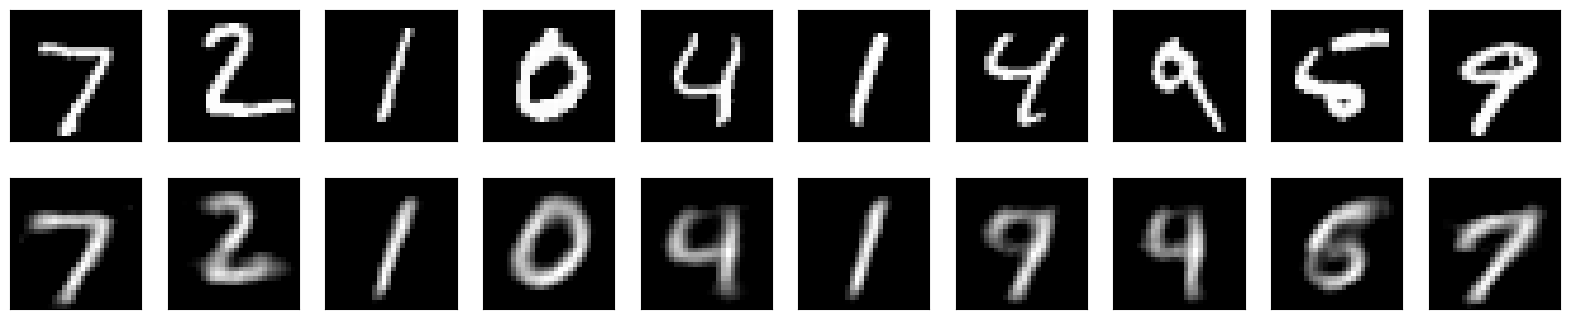

In [11]:
# Show some reconstruction examples from the test set

decoded_imgs = vae.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

79/79 [==============================] - 0s 4ms/step


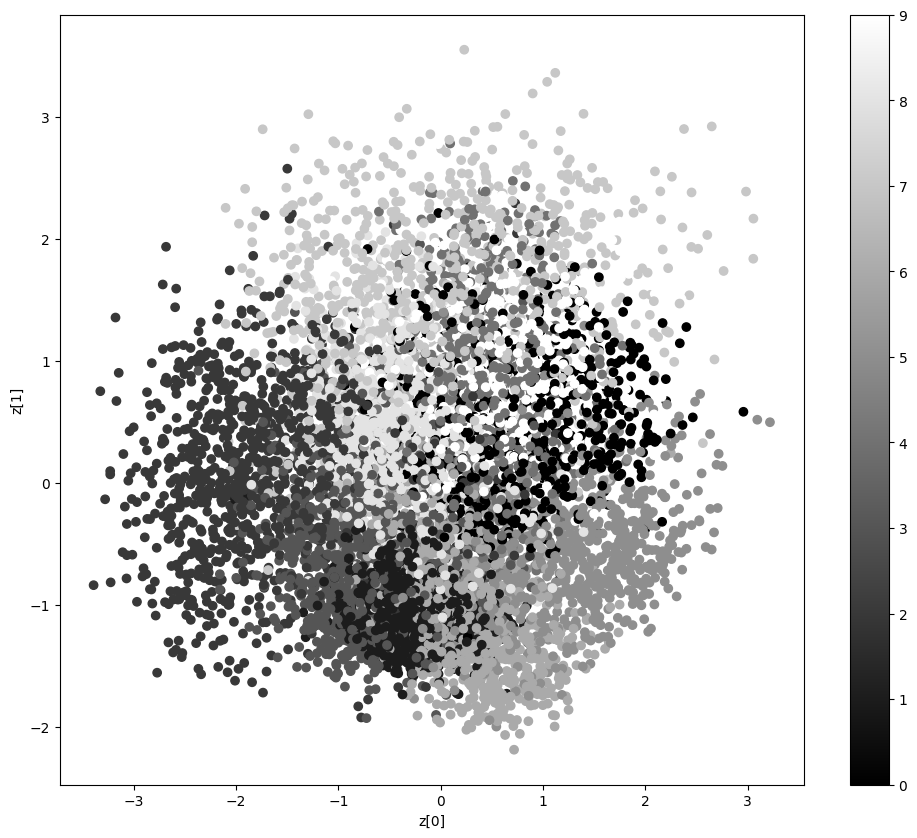

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 16ms/step


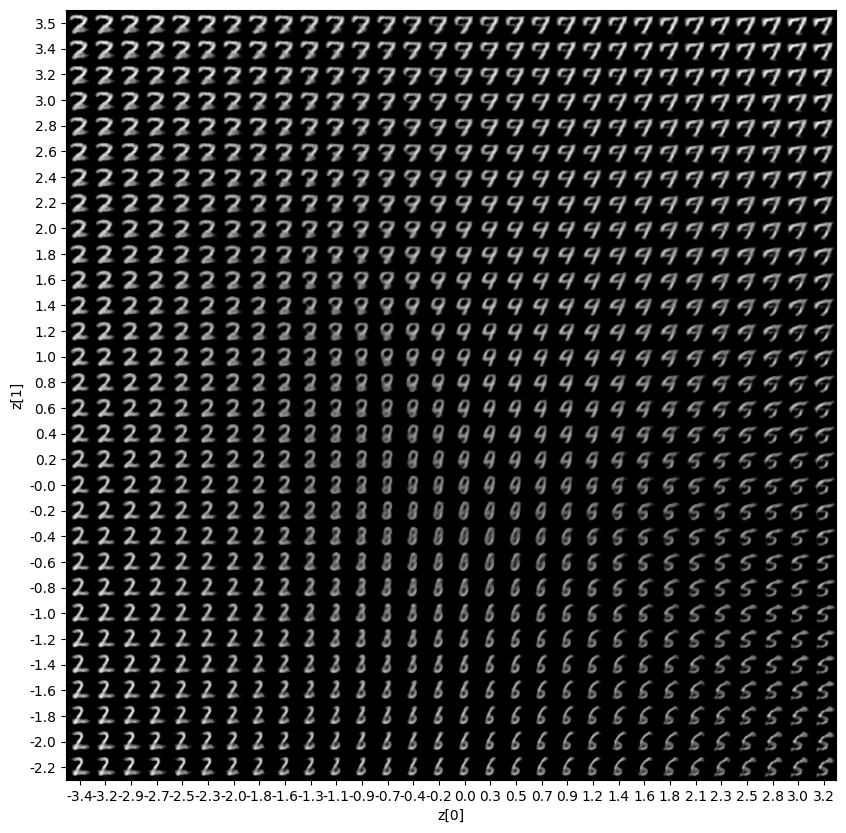

In [12]:
# Plot the latent subspace and generate MNIST images from a grid in latent space
plot_results((encoder,decoder),
            (x_test,y_test),
                 batch_size=batch_size,
                 model_name="vae_mlp")